# Data Scholar :: Code Along :: Classifying SETI Signals to Aid with the Discovery of Extraterrestrial  Life

### Import Libraries

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn import metrics

np.random.seed(42)

import warnings;warnings.simplefilter('ignore')
%matplotlib inline
print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.11.0


### Load & Process Data

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
train_images = pd.read_csv('/content/drive/MyDrive/images.csv', header=None)
train_labels = pd.read_csv('data/train/labels.csv', header=None)

val_images = pd.read_csv('data/validation/images.csv', header=None)
val_labels = pd.read_csv('data/validation/labels.csv', header=None)

In [14]:
train_images.head()

,0,1,2,3,4,5,6,7,8,9,...,8182,8183,8184,8185,8186,8187,8188,8189,8190,8191
0,0.631373,0.623529,0.713726,0.705882,0.658824,0.666667,0.654902,0.635294,0.647059,0.705882,...,0.682353,0.611765,0.650980,0.658824,0.600000,0.603922,0.654902,0.694118,0.658824,0.666667
1,0.725490,0.752941,0.749020,0.701961,0.690196,0.721569,0.709804,0.745098,0.654902,0.721569,...,0.721569,0.698039,0.721569,0.686275,0.713726,0.682353,0.690196,0.698039,0.701961,0.725490
2,0.717647,0.701961,0.713726,0.733333,0.705882,0.717647,0.725490,0.682353,0.717647,0.674510,...,0.709804,0.694118,0.705882,0.682353,0.639216,0.713726,0.670588,0.678431,0.737255,0.674510
3,0.705882,0.674510,0.654902,0.678431,0.666667,0.662745,0.678431,0.662745,0.686275,0.686275,...,0.639216,0.662745,0.631373,0.643137,0.705882,0.662745,0.705882,0.666667,0.654902,0.631373
4,0.647059,0.729412,0.701961,0.674510,0.611765,0.698039,0.713726,0.662745,0.701961,0.674510,...,0.639216,0.670588,0.705882,0.674510,0.721569,0.694118,0.674510,0.705882,0.749020,0.729412


In [15]:
train_labels.head()

,0,1,2,3
0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0


In [16]:
print(train_images.shape, train_labels.shape)

(3200, 8192) (3200, 4)


In [17]:
print(val_images.shape, val_labels.shape)

(800, 8192) (800, 4)


In [18]:
x_train = train_images.values.reshape(3200, 64, 128, 1)
x_val = val_images.values.reshape(800, 64, 128, 1)

y_train = train_labels.values
y_val = val_labels.values

### Plot 2D Spectrograms

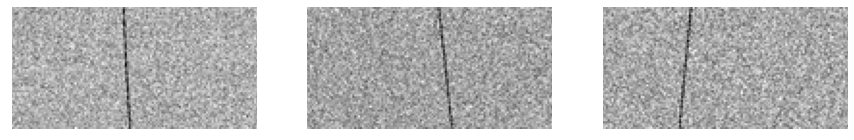

In [19]:
plt.figure(0, figsize=(15, 15))
for i in range(1, 4):
  plt.subplot(1, 3, i)
  img = np.squeeze(x_train[np.random.randint(0, x_train.shape[0])])
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img, cmap='gray')

### Create Training and Validation Data Generators

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen_train = ImageDataGenerator(horizontal_flip=True,
                                   rotation_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2)
datagen_train.fit(x_train)

datagen_val = ImageDataGenerator(horizontal_flip=True,
                                   rotation_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2)
datagen_val.fit(x_val)

### Create the CNN Model

In [21]:
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint

In [22]:
from keras.api._v2.keras import activations
# initatialise the CNN
model = Sequential()

# first convolution 
model.add(Conv2D(32, (5,5), padding='same', input_shape=(64, 128, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# second convolution
model.add(Conv2D(64, (5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# flatten
model.add(Flatten())

# fully connected layer
model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

# out layer
model.add(Dense(4, activation='softmax'))

### Build Learning Rate Scheduler & Compile Model

In [23]:
initial_learning_rate = 0.005

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = initial_learning_rate,
    decay_steps = 5, 
    decay_rate = 0.96,
    staircase=True
)

optimizer = Adam(learning_rate = lr_schedule)

In [24]:
model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 128, 32)       832       
                                                                 
 batch_normalization (BatchN  (None, 64, 128, 32)      128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 64, 128, 32)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 64, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 64, 64)        5

### Train the Model

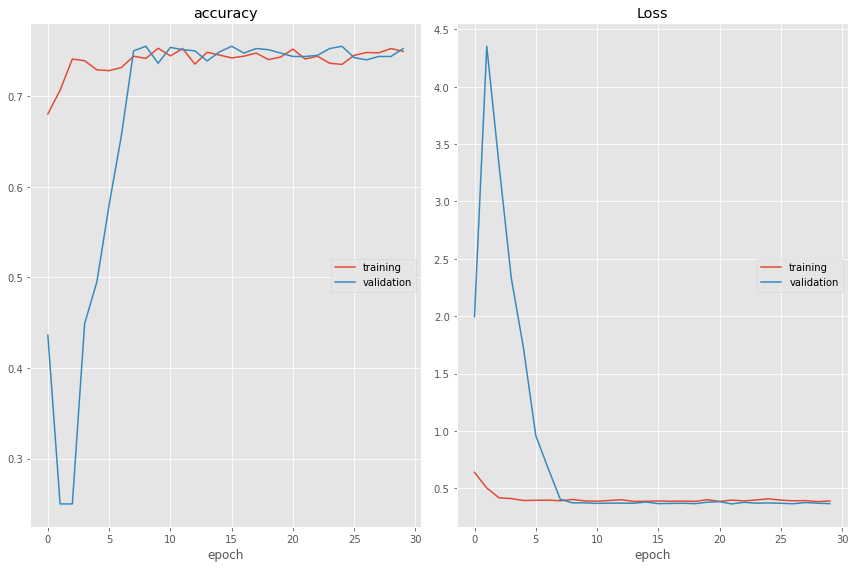

accuracy
	training         	 (min:    0.680, max:    0.753, cur:    0.749)
	validation       	 (min:    0.250, max:    0.755, cur:    0.752)
Loss
	training         	 (min:    0.384, max:    0.639, cur:    0.390)
	validation       	 (min:    0.364, max:    4.353, cur:    0.366)
100/100 [==============================] - 7s 65ms/step - loss: 0.3897 - accuracy: 0.7494 - val_loss: 0.3660 - val_accuracy: 0.7525


In [26]:
from livelossplot.inputs.keras import PlotLossesCallback

checkpoint = ModelCheckpoint('model_weights.hh5', monitor='val_loss',
                             save_weights_only=True, mode='min', verbose = 0)

callbacks = [PlotLossesCallback(), checkpoint]

batch_size = 32

history = model.fit(datagen_train.flow(x_train, y_train, batch_size=batch_size,
                                       shuffle=True), 
                    steps_per_epoch = len(x_train) // batch_size,
                    validation_data = datagen_val.flow(x_val, y_val, batch_size=batch_size,
                                                       shuffle=True),
                    epochs = 30,
                    callbacks=callbacks)

### Evaluate the Model

In [27]:
model.evaluate(x_val, y_val)

25/25 [==============================] - 0s 8ms/step - loss: 0.3575 - accuracy: 0.7550


[0.3575364053249359, 0.7549999952316284]

In [31]:
y_true = np.argmax(y_val, 1)
y_pred = np.argmax(model.predict(x_val), 1)

print(metrics.classification_report(y_true, y_pred))

25/25 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       200
           1       0.51      0.69      0.59       200
           2       0.52      0.34      0.41       200
           3       1.00      1.00      1.00       200

    accuracy                           0.76       800
   macro avg       0.76      0.76      0.75       800
weighted avg       0.76      0.76      0.75       800

